# Random Forest




In [123]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz


import matplotlib.pyplot as plt
from datetime import datetime
import os
import seaborn as sns

# 1- Relevant components

Where i basically steal the entire code for components, and then make one big dataframe containg all the components, type, and catagory.

In [124]:
# functions to extract the relevant components from a csv file file_device contain one week exactly from Monday 00:00:01 to the next Monday
#file device : path to the file, ex : household_power_consumption/solar_panel_325_1.csv

def max_power(file_device):
    "in : path to csv file, string"
    "out : maximum power consumed, float"
    "max_power different from the power max of the file 0, because the power is sumed to resample here"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    #df['time'] = df['timestamp'].dt.time

    max_power = df['power'].max()

    return max_power

    
def use_time(file_device):
    "in : path to csv file, string"
    "out : medium time of use per usage, float"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time

    time_use=0
    number_of_use=0
    in_functionment=False

    for i in df.index:
        if df['power'][i]!=0: 
            time_use+=1
        if not in_functionment and df['power'][i] >= 0:
            in_functionment = True
            number_of_use += 1
        elif in_functionment and df['power'][i] <= 0:
            in_functionment = False

    use_time=time_use/number_of_use

    return use_time

    
def period_use(file_device):
    "in : path to csv file, string"
    "out : when the device is used during the day, string"
    "compter le nombre de min par période ou l'appareil est utlisé"
    "diviser par la durée de chaque période, créer une dernière catégorie non classifié (qui pourrait correspondre à toute"
    "la journée ou à deux périodes d'utilisation...)"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time

    use_morning=0
    use_lunch=0
    use_afternoon=0
    use_evening=0
    use_night=0
    
    night_df = df[(df['time'] >= pd.to_datetime('22:00:00').time()) | (df['time'] < pd.to_datetime('06:00:00').time())]
    for i in night_df.index:
        use_night+=night_df['power'][i]
    use_night=use_night/(8*60)
        
    morning_df = df[(df['time'] >= pd.to_datetime('06:00:00').time()) | (df['time'] < pd.to_datetime('11:00:00').time())]
    for i in morning_df.index:
        use_morning+=morning_df['power'][i]
    use_morning=use_morning/(5*60)
    
    lunch_df = df[(df['time'] >= pd.to_datetime('11:00:00').time()) | (df['time'] < pd.to_datetime('13:30:00').time())]
    for i in lunch_df.index:
        use_lunch+=lunch_df['power'][i]
    use_lunch=use_lunch/(2.5*60)
    
    afternoon_df = df[(df['time'] >= pd.to_datetime('13:30:00').time()) | (df['time'] < pd.to_datetime('18:30:00').time())]
    for i in afternoon_df.index:
        use_afternoon+=afternoon_df['power'][i]
    use_afternoon=use_afternoon/(5*60)
    
    evening_df = df[(df['time'] >= pd.to_datetime('18:30:00').time()) | (df['time'] < pd.to_datetime('22:00:00').time())]
    for i in evening_df.index:
        use_evening+=evening_df['power'][i]
    use_evening=use_evening/(3.5*60)
    
    use_time=[use_morning,use_lunch,use_afternoon,use_evening,use_night]
    use_time_sorted=sorted(use_time, reverse=True)
    second_max=use_time_sorted[1]
    if use_morning==max(use_time) and second_max<0.8*max(use_time):
        return 1
    elif use_lunch==max(use_time) and second_max<0.8*max(use_time):
        return 2
    elif use_afternoon==max(use_time) and second_max<0.8*max(use_time):
        return 3
    elif use_evening==max(use_time) and second_max<0.8*max(use_time):
        return 4
    elif use_night==max(use_time) and second_max<0.8*max(use_time):
        return 5
    else : return 6 #non classified
    

def night(file_device):
    "in : path to csv file, string"
    "out : 1 or 0 : boolean if device is used during the night or not"
    "night : from 10pm to 6am"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time
    
    night_df = df[(df['time'] >= pd.to_datetime('22:00:00').time()) | (df['time'] < pd.to_datetime('06:00:00').time())]
    
    for i in night_df.index:
        #test : non zero value of the power during the night
        if df['power'][i]!=0: return 1
    
    return 0
    
    
    
def number_time(file_device):
    "in : path to csv file, string"
    "out :number of times the device was used, int"
    "the device is used = period of time during which power !=0"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time
    
    number_used=0
    
    for i in df.index:
        if i==0 and df['power'][i]!=0:
            number_used+=1 
        elif df['power'][i]!=0 and df['power'][i-1]==0:
            number_used+=1
            
    return number_used

In [125]:
#function that takes device file and extract the relevant components

def components(file_device):
    "function that takes the 0_smart_plugs_devices.csv and a device csv file and extract the 5 relevant components"
    "file device : path to the file, ex : household_power_consumption/solar_panel_325_1.csv"
    "the file must contain one week exactly from Monday 00:00:01 to the next Monday"
    "out : array of size 5"
    
    compo=np.zeros((1,5))
    
    compo[0,0]=max_power(file_device)
    compo[0,1]=use_time(file_device)
    compo[0,2]=period_use(file_device)
    compo[0,3]=night(file_device)
    compo[0,4]=number_time(file_device)
    
    return compo
    

In [126]:
%run name_and_cat.ipynb

directory = 'csv_files_1week'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')] #select the csv files

column_names = ['Max Power', 'Use Time', 'Period Use', 'Night','Number time','Type','Category']
big_df=pd.DataFrame(columns=column_names)

for file in csv_files : #go through the csv_files
   print(file)
   compo=components(directory+'/'+file)
   type=assign_type_and_group(file)
   name_cat_array= np.array(type)
   name_cat_array_reshaped=name_cat_array.reshape(1,-1)
   new_array = np.concatenate((compo,name_cat_array_reshaped), axis=1)
   new_row_df = pd.DataFrame(new_array, columns=big_df.columns)
   big_df = pd.concat([big_df, new_row_df], ignore_index=True)

3D_printer_29_week_1_minutes.csv
3D_printer_29_week_2_minutes.csv
3D_printer_29_week_3_minutes.csv
air_conditioner_222_week_1_minutes.csv
air_conditioner_222_week_2_minutes.csv
air_conditioner_222_week_3_minutes.csv
air_purifier_293_week_1_minutes.csv
air_purifier_293_week_2_minutes.csv
air_purifier_293_week_3_minutes.csv
boiler_217_week_1_minutes.csv
boiler_217_week_2_minutes.csv
boiler_217_week_3_minutes.csv
boiler_226_week_1_minutes.csv
boiler_226_week_2_minutes.csv
boiler_226_week_3_minutes.csv
boiler_233_week_1_minutes.csv
boiler_233_week_2_minutes.csv
boiler_233_week_3_minutes.csv
boiler_233_week_4_minutes.csv
coffee_37_week_1_minutes.csv
coffee_37_week_2_minutes.csv
coffee_37_week_3_minutes.csv
coffee_54_week_1_minutes.csv
coffee_54_week_2_minutes.csv
coffee_54_week_3_minutes.csv
coffee_54_week_4_minutes.csv
coffee_97_week_1_minutes.csv
coffee_97_week_2_minutes.csv
coffee_97_week_3_minutes.csv
computer_44_week_1_minutes.csv
computer_44_week_2_minutes.csv
computer_44_week_3_minut

In [127]:

print(big_df.head(5))


  Max Power             Use Time Period Use Night Number time            Type  \
0    8520.5   0.1289301540409369        2.0   1.0        16.0      3D printer   
1    8735.0  0.47218818916932126        2.0   1.0        27.0      3D printer   
2    8127.5  0.10377949467529755        2.0   1.0        10.0      3D printer   
3    1453.0   0.7502045268611944        2.0   0.0         5.0  air condtioner   
4    1155.5   1.0017862459065199        2.0   0.0         5.0  air condtioner   

     Category  
0  multimedia  
1  multimedia  
2  multimedia  
3     cooling  
4     cooling  
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    Max Power             Use Time Period Use Night Number time  \
128  149388.5    5.085031623330991        2.0   1.0         3.0   
129  150754.0  0.33866852238459755        2.0   1.0         2.0   
130  127392.0              10080.0        2.0   1.0         1.0   
131  128105.0              10080.0        2.0   1.0         1.0   
132  126128.0            

# 2- Random Forest and classification

We now have one dataframe containing both the features, as well as the types and catagories.
We facotrize the type and catagories 

In [128]:
%run name_and_cat.ipynb

X = big_df.iloc[:,0:5].values
y=big_df["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

next is to try and optimize to find the best number of n-estimators as well as number of features.

### Random Forest with Appliances(Type)

In [129]:
train_scores = []
test_scores = []
rf = RandomForestClassifier(warm_start=True, random_state=0)
estimator_range = range(1, 100, 1)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

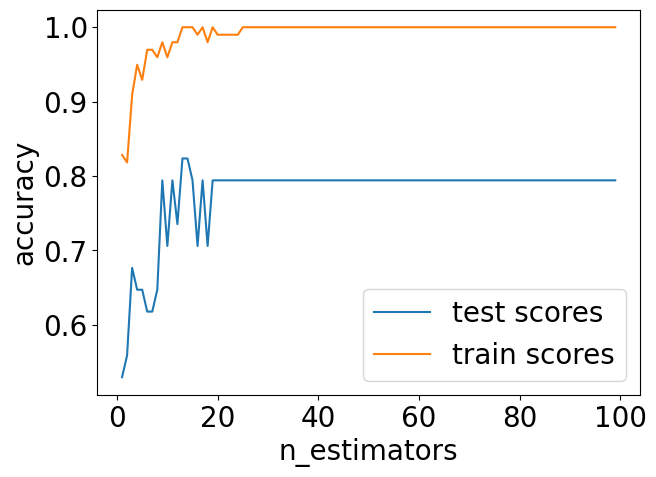

In [130]:
plt.figure(figsize=(7,5))
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("n_estimators", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20)

In [131]:
# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)

# Find the index of the maximum test score
max_test_score_index = np.argmax(test_scores_np)

# Retrieve the corresponding value of n_estimators and its associated test score
best_n_estimators = estimator_range[max_test_score_index]
best_test_score = test_scores_np[max_test_score_index]

print("Best number of estimators:", best_n_estimators)
print("Highest test score:", best_test_score)

Best number of estimators: 13
Highest test score: 0.8235294117647058


In [132]:
train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 5)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True, n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

Text(0.5, 0, 'max_features')

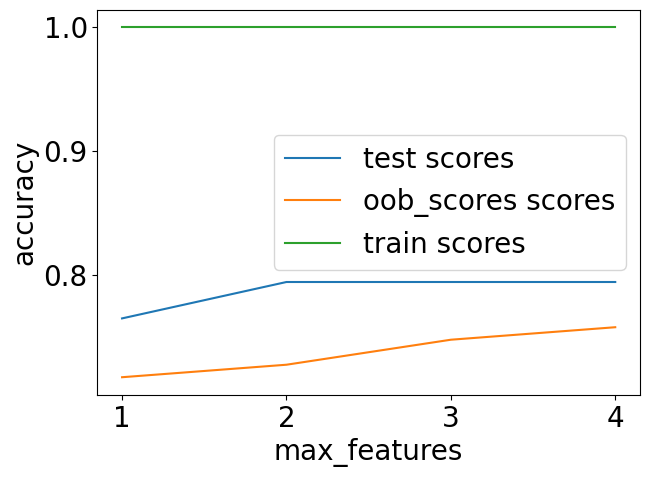

In [133]:
plt.figure(figsize=(7,5))
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("max_features", fontsize=20)

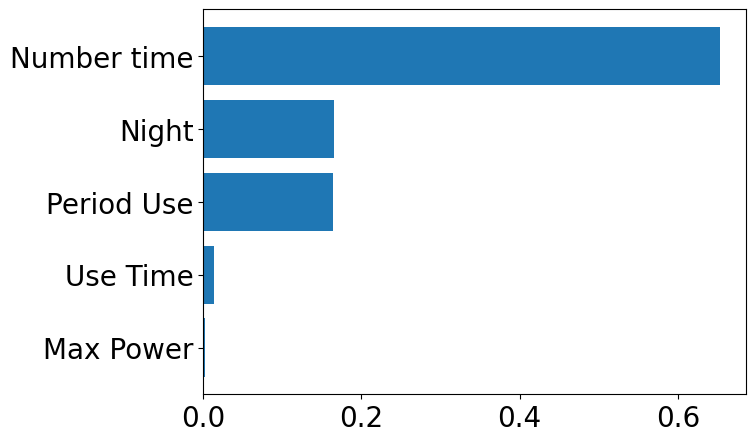

In [134]:
feat_imp=rf.feature_importances_
feat_imp.sort()
plt.figure(figsize=(7,5))
plt.barh(range(5), np.sort(rf.feature_importances_[0:5]))
plt.yticks(range(5), big_df.columns.tolist()[0:5])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

### Random Forest with Catagories

In [135]:
%run name_and_cat.ipynb

X = big_df.iloc[:,0:5].values
y=big_df["Category"] #This value is changed from "type" to "catagory"

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [136]:
train_scores = []
test_scores = []
rf = RandomForestClassifier(warm_start=True, random_state=0)
estimator_range = range(1, 100, 1)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

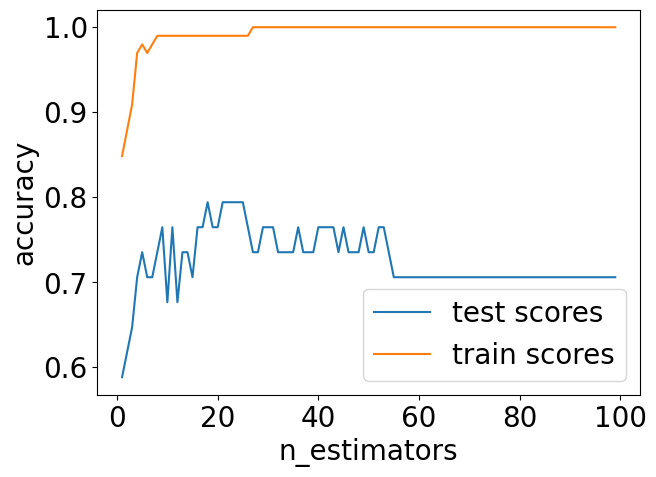

In [137]:
plt.figure(figsize=(7,5))
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("n_estimators", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20)

In [138]:
# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)

# Find the index of the maximum test score
max_test_score_index = np.argmax(test_scores_np)

# Retrieve the corresponding value of n_estimators and its associated test score
best_n_estimators = estimator_range[max_test_score_index]
best_test_score = test_scores_np[max_test_score_index]

print("Best number of estimators:", best_n_estimators)
print("Highest test score:", best_test_score)

Best number of estimators: 18
Highest test score: 0.7941176470588235


In [139]:
train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 5)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True, n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

Text(0.5, 0, 'max_features')

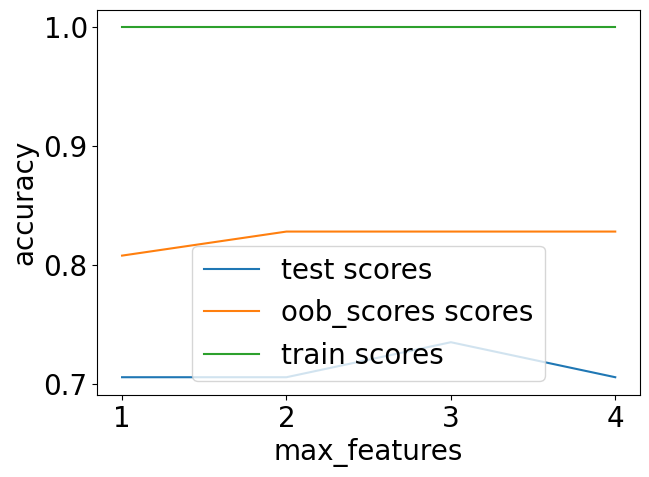

In [140]:
plt.figure(figsize=(7,5))
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("max_features", fontsize=20)

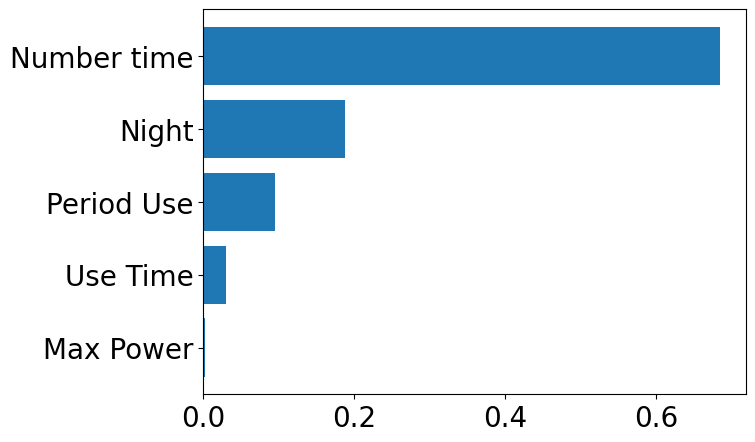

In [141]:
feat_imp=rf.feature_importances_
feat_imp.sort()
plt.figure(figsize=(7,5))
plt.barh(range(5), np.sort(rf.feature_importances_[0:5]))
plt.yticks(range(5), big_df.columns.tolist()[0:5])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

### WITHOUT OTHER
we want to remove the other catagory here.

In [142]:
%run name_and_cat.ipynb
excluded_dataframe=big_df[big_df['Category'] != 'other']
X = excluded_dataframe.iloc[:,0:5].values
y=excluded_dataframe["Category"] #This value is changed from "type" to "catagory"

print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y)

0      multimedia
1      multimedia
2      multimedia
3         cooling
4         cooling
          ...    
128       washing
129       washing
130       washing
131       washing
132       washing
Name: Category, Length: 110, dtype: object


In [143]:
train_scores = []
test_scores = []
rf = RandomForestClassifier(warm_start=True, random_state=0)
estimator_range = range(1, 100, 1)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

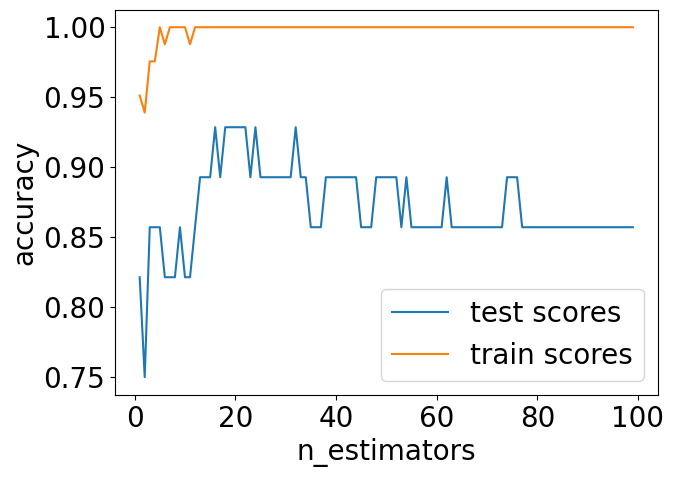

In [144]:
plt.figure(figsize=(7,5))
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("n_estimators", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20)

In [145]:
# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)

# Find the index of the maximum test score
max_test_score_index = np.argmax(test_scores_np)

# Retrieve the corresponding value of n_estimators and its associated test score
best_n_estimators = estimator_range[max_test_score_index]
best_test_score = test_scores_np[max_test_score_index]

print("Best number of estimators:", best_n_estimators)
print("Highest test score:", best_test_score)

Best number of estimators: 16
Highest test score: 0.9285714285714286


In [146]:
train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 5)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True, n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

Text(0.5, 0, 'max_features')

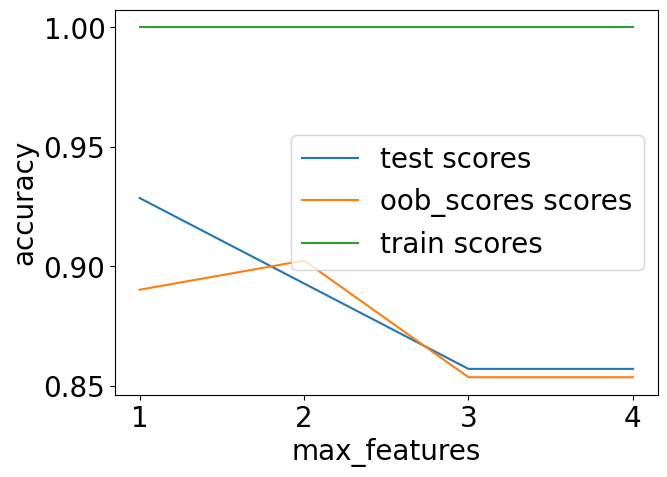

In [147]:
plt.figure(figsize=(7,5))
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("max_features", fontsize=20)

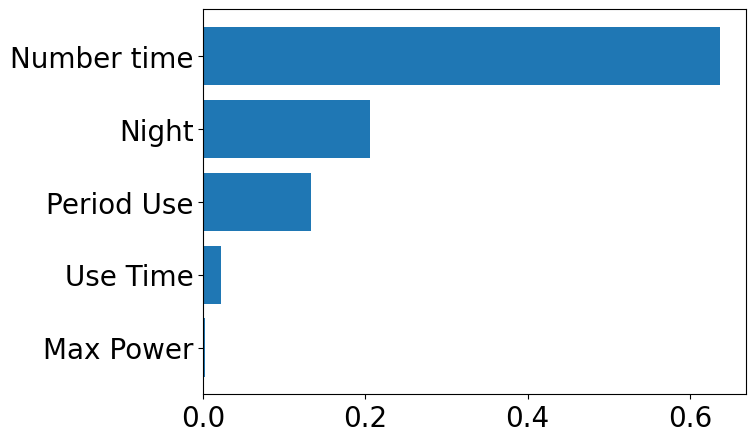

In [148]:
feat_imp=rf.feature_importances_
feat_imp.sort()
plt.figure(figsize=(7,5))
plt.barh(range(5), np.sort(rf.feature_importances_[0:5]))
plt.yticks(range(5), big_df.columns.tolist()[0:5])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)